In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import os

# --- 0. プロット設定 ---
plt.rcParams['font.family'] = "Meiryo"
plt.rcParams['figure.dpi'] = 100

ArviZスタイルのLOO-CV比較グラフを作成します...


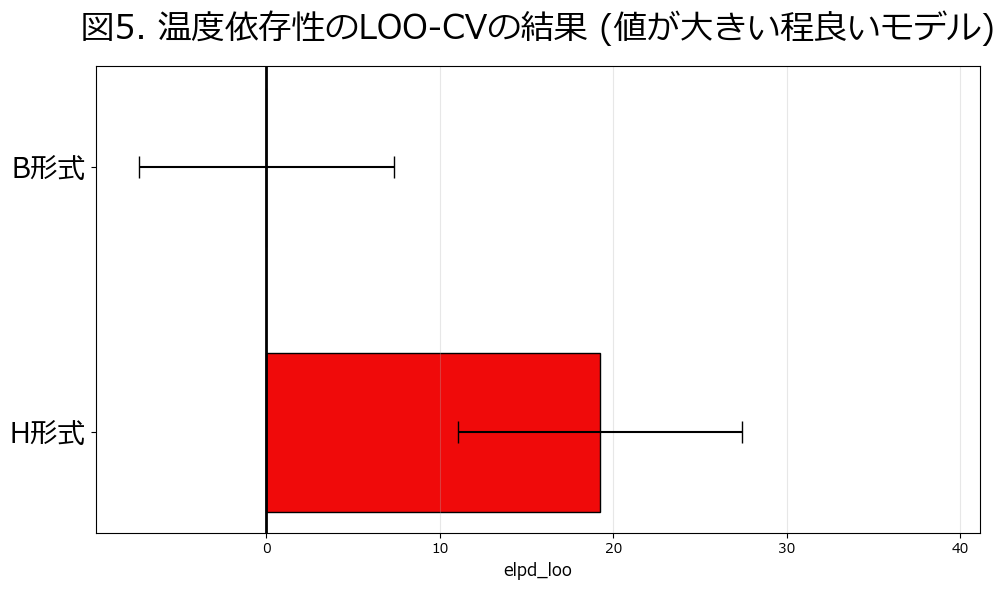

グラフの作成が完了し、ファイルとして保存されました。


In [10]:
import numpy as np
import matplotlib.pyplot as plt

# データの定義（前のセルで定義されたものと同じ）
model_comparison_data = {
    'H形式': {'WAIC': 298.00, 'WAIC_se': 35.58, 'LOO': 71.787650, 'LOO_se': 8.196089},
    'B形式': {'WAIC': 294.94, 'WAIC_se': 35.29, 'LOO': 52.557482, 'LOO_se': 7.360395}
}

def plot_loo_arviz_style(data):
    """ArviZスタイルのLOO-CV比較グラフを作成する関数"""
    models = list(data.keys())
    loo_values = [data[model]['LOO'] for model in models]
    loo_errors = [data[model]['LOO_se'] for model in models]
    
    # 基準値（最良モデル）を設定
    best_loo = min(loo_values)
    relative_loo = [loo - best_loo for loo in loo_values]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 横棒グラフを作成（基準点からの相対値）
    y_pos = np.arange(len(models))
    
    # 最良モデル（差分=0）には塗りつぶしバー、他は白抜きバー
    for i, (model, rel_val, error) in enumerate(zip(models, relative_loo, loo_errors)):
        if rel_val == 0:  # 最良モデル
            color = 'white'
            alpha = 0.8
        else:  # 他のモデル
            color = "#F00A0A"
            alpha = 1.0
            
        bar = ax.barh(i, rel_val, xerr=error, capsize=8, 
                     color=color, edgecolor='black', alpha=alpha, height=0.6)
    
    # 基準線（ゼロライン）を描画
    ax.axvline(x=0, color='black', linestyle='-', linewidth=2)
    
    # ラベルとタイトル
    ax.set_xlabel('elpd_loo', fontsize=12)
    ax.set_title('図5. 温度依存性のLOO-CVの結果 (値が大きい程良いモデル)', fontsize=24, pad=20)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models, fontsize=20)
    ax.grid(True, axis='x', linestyle='-', alpha=0.3)
    
    # 右側に数値を表示
    for i, (model, rel_val, error, abs_val) in enumerate(zip(models, relative_loo, loo_errors, loo_values)):
        if rel_val == 0:  # 最良モデル
            text = f'{rel_val:.1f}±{error:.1f}'
        else:  # 他のモデル
            text = f'{rel_val:.1f}±{error:.1f}'
        
        #ax.text(max(relative_loo) * 1.1, i, text, va='baseline', ha='left', fontsize=16, color='black')

    # X軸の範囲を調整
    x_max = max(relative_loo) + max(loo_errors)
    x_min = min(relative_loo) - max(loo_errors)
    ax.set_xlim(x_min * 1.2, x_max * 1.5)
    
    # レイアウト調整
    plt.tight_layout()
    plt.savefig("loo_cv_arviz_style.png", dpi=300, bbox_inches='tight')
    plt.show()

# ArviZスタイルのLOO-CVグラフを作成
print("ArviZスタイルのLOO-CV比較グラフを作成します...")
plot_loo_arviz_style(model_comparison_data)
print("グラフの作成が完了し、ファイルとして保存されました。")

In [14]:
a_B = 0.583047
a_H = 0.633144
g_B = 2.012732
g_H = 2.006233
kB = 1.380649e-23; muB = 9.274010e-24; hbar = 1.054571e-34
c = 299792458; mu0 = 4.0 * np.pi * 1e-7
s = 3.5; N_spin = 24 / 1.238 * 1e27
G0_H = a_H * mu0 * N_spin * (g_H * muB)**2 / (2 * hbar)
G0_B = a_B* mu0 * N_spin * (g_B * muB)**2 / (2 * hbar)
print(f"B形式: {G0_B * 10**-9}")
print(f"H形式: {G0_H * 10**-9}")

B形式: 23.464171736857274
H形式: 25.31599468535199


In [3]:
def analyze_transmittance(df, freq_col, transmittance_col):
    """
    指定された透過率データに対して、正規化、ピーク検出、背景補正、FWHM計算、膜厚計算、プロットを行う。

    Args:
        df (pd.DataFrame): 周波数と透過率を含むデータフレーム。
        freq_col (str): 周波数データの列名。
        transmittance_col (str): 分析対象の透過率データの列名。
        
    Returns:
        tuple: (周波数, 補正後透過率, 背景) のタプル。エラー時は (None, None, None)。
    """
    print(f"--- {transmittance_col} の分析を開始 ---")

    exp_freq_thz = df[freq_col].to_numpy(dtype=float)
    exp_transmittance_original = df[transmittance_col].to_numpy(dtype=float)

    # --- データ正規化 (Min-Max Normalization) ---
    min_val = np.min(exp_transmittance_original)
    max_val = np.max(exp_transmittance_original)
    if np.isclose(max_val, min_val):
        print("エラー: データの値がほぼ一定であるため、正規化できません。分析をスキップします。")
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(exp_freq_thz, exp_transmittance_original, 'o', color='gray', markersize=3, alpha=0.5, label='実験データ (元)')
        ax.set_title(f'正規化エラー ({transmittance_col}) - データが一定値')
        ax.set_xlabel('周波数 (THz)')
        ax.set_ylabel('透過率')
        ax.legend()
        plt.show()
        plt.close()
        print(f"--- {transmittance_col} の分析が完了 ---\n")
        return None, None, None
        
    exp_transmittance_normalized = (exp_transmittance_original - min_val) / (max_val - min_val)
    print("データの正規化が完了しました。")

    # 1. バレーの検出 (正規化データに対して実行)
    y_inverted_all = -exp_transmittance_normalized
    valley_indices_all, _ = find_peaks(y_inverted_all, prominence=0.01)
    
    if len(valley_indices_all) < 2:
        print("エラー: 背景補正に必要な数の谷が検出されていません。")
        # エラー時でもプロットは行う
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(exp_freq_thz, exp_transmittance_original, 'o', color='gray', markersize=3, alpha=0.5, label='実験データ (元)')
        if len(valley_indices_all) > 0:
            valley_data_all = df.iloc[valley_indices_all]
            ax.plot(valley_data_all[freq_col], valley_data_all[transmittance_col], 'v', color='red', markersize=10, label='検出された谷')
        ax.set_title(f'谷検出エラー ({transmittance_col})')
        ax.legend()
        plt.show()
        plt.close()
        return None, None, None

    # 2. 背景補正 (2次多項式フィッティング)
    valley_freqs = df[freq_col].iloc[valley_indices_all].to_numpy()
    valley_transmittance_norm = exp_transmittance_normalized[valley_indices_all]
    
    # 2次多項式でフィッティング
    coeffs = np.polyfit(valley_freqs, valley_transmittance_norm, 2)
    
    # 全周波数範囲で背景を計算
    background = np.polyval(coeffs, exp_freq_thz)
    
    # 背景を差し引いて補正
    exp_transmittance_corrected = exp_transmittance_normalized - background
    
    # --- 補正後データのリスケール [0, 1] ---
    corrected_min = np.min(exp_transmittance_corrected)
    corrected_max = np.max(exp_transmittance_corrected)
    if not np.isclose(corrected_max, corrected_min):
        exp_transmittance_corrected = (exp_transmittance_corrected - corrected_min) / (corrected_max - corrected_min)
    print("補正後データを[0, 1]の範囲にリスケールしました。")
    
    # 3. 補正後データのピーク再検出とFWHM計算
    corrected_peak_indices, _ = find_peaks(exp_transmittance_corrected, height=0.01)
    if len(corrected_peak_indices) == 0:
        print("エラー: 補正後のデータに顕著なピークが見つかりませんでした。")
        return exp_freq_thz, exp_transmittance_corrected, background

    widths_info = peak_widths(exp_transmittance_corrected, corrected_peak_indices, rel_height=0.5)
    width_heights, left_ips, right_ips = widths_info[1], widths_info[2], widths_info[3]

    freq_axis = df[freq_col].to_numpy()
    index_axis = np.arange(len(freq_axis))
    left_freqs = np.interp(left_ips, index_axis, freq_axis)
    right_freqs = np.interp(right_ips, index_axis, freq_axis)
    fwhm_in_thz = right_freqs - left_freqs

    corrected_peak_freqs = freq_axis[corrected_peak_indices]
    
    print("\n--- 半値幅 (FWHM) ---")
    for i, peak_idx in enumerate(corrected_peak_indices):
        print(f"ピーク (周波数: {corrected_peak_freqs[i]:.4f} THz) の半値幅: {fwhm_in_thz[i]:.4f} THz")
    
    try:
        gamma_average = np.mean(fwhm_in_thz[1:4])
        gamma_average_cav = np.mean(fwhm_in_thz[2:4])
        print(f"平均半値幅: {gamma_average:.4f} THz")
        print(f"平均半値幅 (共振器): {gamma_average_cav:.4f} THz")
    except IndexError:
        print("半値幅の平均計算に必要なピーク数が足りません。")


    # 4. 膜厚の計算
    def calculate_thickness_from_peaks(j, peak_freqs_local):
        c = 299792458
        n = 3.8
        peak_freq_hz = peak_freqs_local * 1e12
        d_calculated = j * (c / (2 * n)) / peak_freq_hz
        return d_calculated * 1e6

    d_calculated = []
    print("\n--- 膜厚の計算 ---")
    for j in range(2, 4):
        if j < len(corrected_peak_freqs):
            thickness = calculate_thickness_from_peaks(j, corrected_peak_freqs[j])
            d_calculated.append(thickness)
            print(f"{j}次周波数 ({corrected_peak_freqs[j]:.4f} THz) に基づく膜厚: {thickness:.3f}μm")

    if d_calculated:
        d_average = np.mean(d_calculated)
        print(f"平均膜厚: {d_average:.3f}μm")

    # 5. 結果の可視化
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 元のデータと背景
    ax.plot(exp_freq_thz, exp_transmittance_original, 'o', color='gray', markersize=3, alpha=0.5, label='実験データ (元)')
    ax.set_xlabel('周波数 (THz)')
    ax.set_ylabel('透過率 (元スケール)', color='gray')
    ax.tick_params(axis='y', labelcolor='gray')
    
    # 正規化スケールでの背景プロット用の第2Y軸
    ax_norm = ax.twinx()
    ax_norm.plot(exp_freq_thz, background, color='purple', linestyle='--', alpha=0.7, label='背景 (2次多項式)')
    ax_norm.set_ylabel('正規化透過率スケール', color='purple')
    ax_norm.tick_params(axis='y', labelcolor='purple')
    ax_norm.spines['right'].set_position(('outward', 60))


    # 補正後のデータを別のy軸にプロット
    ax2 = ax.twinx()
    ax2.plot(exp_freq_thz, exp_transmittance_corrected, 'o', color='orange', markersize=4, label='実験データ (正規化・背景補正後)')
    if len(corrected_peak_indices) > 0:
        ax2.hlines(width_heights, left_freqs, right_freqs, color="red", lw=3, label="半値幅 (FWHM)")
        ax2.plot(freq_axis[corrected_peak_indices], exp_transmittance_corrected[corrected_peak_indices], 'x', color='blue', markersize=10, label='検出されたピーク')
    ax2.set_ylabel('透過率 (補正後, a.u.)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.axhline(0, color='black', linestyle='--')
    # ax2.set_ylim(bottom=-0.05) # y軸の下限を設定

    # 凡例をまとめる
    lines, labels = ax.get_legend_handles_labels()
    lines_norm, labels_norm = ax_norm.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines_norm + lines2, labels + labels_norm + labels2, loc='best')

    ax.set_title(f'実験結果 ({transmittance_col})')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"--- {transmittance_col} の分析が完了 ---\n")
    return exp_freq_thz, exp_transmittance_corrected, background

In [4]:
def process_file_and_save(file_path, sheet_name, freq_col, target_columns, output_filename):
    """
    指定されたExcelファイルを読み込み、複数の透過率データ列を分析し、
    補正後のデータを新しいExcelファイルに保存する。

    Args:
        file_path (str): 入力Excelファイルのパス。
        sheet_name (str): 読み込むシート名。
        freq_col (str): 周波数データが含まれる列の名前。
        target_columns (list): 分析対象の透過率データ列名のリスト。
        output_filename (str): 出力するExcelファイル名。
    """
    print(f"====== ファイル '{file_path}' の処理を開始 ======")
    # --- 1. データの読み込み ---
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
        print(f"データの読み込みに成功しました。読み込み件数: {len(df)}件")
        print("列名:", df.columns.tolist())
    except FileNotFoundError:
        print(f"エラー: ファイルが見つかりません。パスを確認してください。\nパス: {file_path}")
        return
    except Exception as e:
        print(f"データの読み込み中にエラーが発生しました: {e}")
        return

    # --- 2. 各列の分析を実行 ---
    results = {}
    for col in target_columns:
        if col in df.columns:
            freq, corrected_trans, background = analyze_transmittance(df, freq_col, col)
            if freq is not None:
                results[col] = {
                    'frequency': freq,
                    'corrected_transmittance': corrected_trans,
                    'background': background
                }
        else:
            print(f"警告: 列 '{col}' がデータフレームに見つかりません。スキップします。")

    # --- 3. 補正後データのExcelファイルへの保存 ---
    if results:
        # 最初の有効な結果から周波数データを取得
        first_key = next(iter(results))
        df_to_save = pd.DataFrame({freq_col: results[first_key]['frequency']})

        # 各データセットの補正後透過率を列として追加
        for col_name, data in results.items():
            df_to_save[f'{col_name}'] = data['corrected_transmittance']

        # 保存先ディレクトリとファイル名を設定
        output_dir = "corrected_exp_datasets"
        output_filepath = os.path.join(output_dir, output_filename)

        try:
            # ディレクトリが存在しない場合は作成
            os.makedirs(output_dir, exist_ok=True)
            
            # Excelファイルとして保存
            df_to_save.to_excel(output_filepath, index=False, sheet_name='Corrected Data')
            print(f"\n補正後のデータを '{output_filepath}' に保存しました。")
            print("保存された列:", df_to_save.columns.tolist())
        except Exception as e:
            print(f"\nファイルの保存中にエラーが発生しました: {e}")
    else:
        print("\n保存するデータがありません。")
    
    print(f"====== ファイル '{file_path}' の処理が完了 ======\n")

In [5]:
def analyze_transmittance_linear_bg(df, freq_col, transmittance_col):
    """
    指定された透過率データに対して、正規化、ピーク検出、線形補間による背景補正、FWHM計算、膜厚計算、プロットを行う。

    Args:
        df (pd.DataFrame): 周波数と透過率を含むデータフレーム。
        freq_col (str): 周波数データの列名。
        transmittance_col (str): 分析対象の透過率データの列名。
        
    Returns:
        tuple: (周波数, 補正後透過率, 背景) のタプル。エラー時は (None, None, None)。
    """
    print(f"--- {transmittance_col} の分析を開始 (線形補間背景補正) ---")

    exp_freq_thz = df[freq_col].to_numpy(dtype=float)
    exp_transmittance_original = df[transmittance_col].to_numpy(dtype=float)

    # --- データ正規化 (Min-Max Normalization) ---
    min_val = np.min(exp_transmittance_original)
    max_val = np.max(exp_transmittance_original)
    if np.isclose(max_val, min_val):
        print("エラー: データの値がほぼ一定であるため、正規化できません。分析をスキップします。")
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(exp_freq_thz, exp_transmittance_original, 'o', color='gray', markersize=3, alpha=0.5, label='実験データ (元)')
        ax.set_title(f'正規化エラー ({transmittance_col}) - データが一定値')
        ax.set_xlabel('周波数 (THz)')
        ax.set_ylabel('透過率')
        ax.legend()
        plt.show()
        plt.close()
        print(f"--- {transmittance_col} の分析が完了 ---\n")
        return None, None, None
        
    exp_transmittance_normalized = (exp_transmittance_original - min_val) / (max_val - min_val)
    print("データの正規化が完了しました。")

    # 1. バレーの検出 (正規化データに対して実行)
    y_inverted_all = -exp_transmittance_normalized
    valley_indices_all, _ = find_peaks(y_inverted_all, prominence=0.01)
    
    if len(valley_indices_all) < 2:
        print("エラー: 背景補正に必要な数の谷が検出されていません。")
        # エラー時でもプロットは行う
        fig, ax = plt.subplots(figsize=(12, 7))
        ax.plot(exp_freq_thz, exp_transmittance_original, 'o', color='gray', markersize=3, alpha=0.5, label='実験データ (元)')
        if len(valley_indices_all) > 0:
            valley_data_all = df.iloc[valley_indices_all]
            ax.plot(valley_data_all[freq_col], valley_data_all[transmittance_col], 'v', color='red', markersize=10, label='検出された谷')
        ax.set_title(f'谷検出エラー ({transmittance_col})')
        ax.legend()
        plt.show()
        plt.close()
        return None, None, None

    # 2. 背景補正 (線形補間)
    valley_freqs = df[freq_col].iloc[valley_indices_all].to_numpy()
    valley_transmittance_norm = exp_transmittance_normalized[valley_indices_all]
    
    # 線形補間で背景を計算
    background = np.interp(exp_freq_thz, valley_freqs, valley_transmittance_norm)
    
    # 背景を差し引いて補正
    exp_transmittance_corrected = exp_transmittance_normalized - background
    
    # --- 補正後データのリスケール [0, 1] ---
    corrected_min = np.min(exp_transmittance_corrected)
    corrected_max = np.max(exp_transmittance_corrected)
    if not np.isclose(corrected_max, corrected_min):
        exp_transmittance_corrected = (exp_transmittance_corrected - corrected_min) / (corrected_max - corrected_min)
    print("補正後データを[0, 1]の範囲にリスケールしました。")
    
    # 3. 補正後データのピーク再検出とFWHM計算
    corrected_peak_indices, _ = find_peaks(exp_transmittance_corrected, height=0.01)
    if len(corrected_peak_indices) == 0:
        print("エラー: 補正後のデータに顕著なピークが見つかりませんでした。")
        return exp_freq_thz, exp_transmittance_corrected, background

    widths_info = peak_widths(exp_transmittance_corrected, corrected_peak_indices, rel_height=0.5)
    width_heights, left_ips, right_ips = widths_info[1], widths_info[2], widths_info[3]

    freq_axis = df[freq_col].to_numpy()
    index_axis = np.arange(len(freq_axis))
    left_freqs = np.interp(left_ips, index_axis, freq_axis)
    right_freqs = np.interp(right_ips, index_axis, freq_axis)
    fwhm_in_thz = right_freqs - left_freqs

    corrected_peak_freqs = freq_axis[corrected_peak_indices]
    
    print("\n--- 半値幅 (FWHM) ---")
    for i, peak_idx in enumerate(corrected_peak_indices):
        print(f"ピーク (周波数: {corrected_peak_freqs[i]:.4f} THz) の半値幅: {fwhm_in_thz[i]:.4f} THz")
    
    try:
        gamma_average = np.mean(fwhm_in_thz[1:4])
        gamma_average_cav = np.mean(fwhm_in_thz[2:4])
        print(f"平均半値幅: {gamma_average:.4f} THz")
        print(f"平均半値幅 (共振器): {gamma_average_cav:.4f} THz")
    except IndexError:
        print("半値幅の平均計算に必要なピーク数が足りません。")

    # 4. 膜厚の計算
    def calculate_thickness_from_peaks(j, peak_freqs_local):
        c = 299792458
        n = 3.8
        peak_freq_hz = peak_freqs_local * 1e12
        d_calculated = j * (c / (2 * n)) / peak_freq_hz
        return d_calculated * 1e6

    d_calculated = []
    print("\n--- 膜厚の計算 ---")
    for j in range(2, 4):
        if j < len(corrected_peak_freqs):
            thickness = calculate_thickness_from_peaks(j, corrected_peak_freqs[j])
            d_calculated.append(thickness)
            print(f"{j}次周波数 ({corrected_peak_freqs[j]:.4f} THz) に基づく膜厚: {thickness:.3f}μm")

    if d_calculated:
        d_average = np.mean(d_calculated)
        print(f"平均膜厚: {d_average:.3f}μm")

    # 5. 結果の可視化
    fig, ax = plt.subplots(figsize=(12, 7))
    
    # 元のデータと背景
    ax.plot(exp_freq_thz, exp_transmittance_original, 'o', color='gray', markersize=3, alpha=0.5, label='実験データ (元)')
    ax.set_xlabel('周波数 (THz)')
    ax.set_ylabel('透過率 (元スケール)', color='gray')
    ax.tick_params(axis='y', labelcolor='gray')
    
    # 正規化スケールでの背景プロット用の第2Y軸
    ax_norm = ax.twinx()
    ax_norm.plot(exp_freq_thz, background, color='purple', linestyle='--', alpha=0.7, label='背景 (線形補間)')
    ax_norm.set_ylabel('正規化透過率スケール', color='purple')
    ax_norm.tick_params(axis='y', labelcolor='purple')
    ax_norm.spines['right'].set_position(('outward', 60))

    # 補正後のデータを別のy軸にプロット
    ax2 = ax.twinx()
    ax2.plot(exp_freq_thz, exp_transmittance_corrected, 'o', color='orange', markersize=4, label='実験データ (正規化・背景補正後)')
    if len(corrected_peak_indices) > 0:
        ax2.hlines(width_heights, left_freqs, right_freqs, color="red", lw=3, label="半値幅 (FWHM)")
        ax2.plot(freq_axis[corrected_peak_indices], exp_transmittance_corrected[corrected_peak_indices], 'x', color='blue', markersize=10, label='検出されたピーク')
    ax2.set_ylabel('透過率 (補正後, a.u.)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.axhline(0, color='black', linestyle='--')

    # 凡例をまとめる
    lines, labels = ax.get_legend_handles_labels()
    lines_norm, labels_norm = ax_norm.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines_norm + lines2, labels + labels_norm + labels2, loc='best')

    ax.set_title(f'実験結果 ({transmittance_col}) - 線形補間背景補正')
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()
    print(f"--- {transmittance_col} の分析が完了 ---\n")
    return exp_freq_thz, exp_transmittance_corrected, background

In [6]:
def process_file_and_save_linear_bg(file_path, sheet_name, freq_col, target_columns, output_filename):
    """
    指定されたExcelファイルを読み込み、複数の透過率データ列を線形補間による背景補正で分析し、
    補正後のデータを新しいExcelファイルに保存する。

    Args:
        file_path (str): 入力Excelファイルのパス。
        sheet_name (str): 読み込むシート名。
        freq_col (str): 周波数データが含まれる列の名前。
        target_columns (list): 分析対象の透過率データ列名のリスト。
        output_filename (str): 出力するExcelファイル名。
    """
    print(f"====== ファイル '{file_path}' の処理を開始 (線形補間背景補正) ======")
    # --- 1. データの読み込み ---
    try:
        df = pd.read_excel(file_path, sheet_name=sheet_name, header=0)
        print(f"データの読み込みに成功しました。読み込み件数: {len(df)}件")
        print("列名:", df.columns.tolist())
    except FileNotFoundError:
        print(f"エラー: ファイルが見つかりません。パスを確認してください。\nパス: {file_path}")
        return
    except Exception as e:
        print(f"データの読み込み中にエラーが発生しました: {e}")
        return

    # --- 2. 各列の分析を実行（線形補間背景補正版） ---
    results = {}
    for col in target_columns:
        if col in df.columns:
            freq, corrected_trans, background = analyze_transmittance_linear_bg(df, freq_col, col)
            if freq is not None:
                results[col] = {
                    'frequency': freq,
                    'corrected_transmittance': corrected_trans,
                    'background': background
                }
        else:
            print(f"警告: 列 '{col}' がデータフレームに見つかりません。スキップします。")

    # --- 3. 補正後データのExcelファイルへの保存 ---
    if results:
        # 最初の有効な結果から周波数データを取得
        first_key = next(iter(results))
        df_to_save = pd.DataFrame({freq_col: results[first_key]['frequency']})

        # 各データセットの補正後透過率を列として追加
        for col_name, data in results.items():
            df_to_save[f'{col_name}'] = data['corrected_transmittance']

        # 保存先ディレクトリとファイル名を設定
        output_dir = "corrected_exp_datasets_linear"
        output_filepath = os.path.join(output_dir, output_filename)

        try:
            # ディレクトリが存在しない場合は作成
            os.makedirs(output_dir, exist_ok=True)
            
            # Excelファイルとして保存
            df_to_save.to_excel(output_filepath, index=False, sheet_name='Corrected Data Linear')
            print(f"\n補正後のデータを '{output_filepath}' に保存しました。")
            print("保存された列:", df_to_save.columns.tolist())
        except Exception as e:
            print(f"\nファイルの保存中にエラーが発生しました: {e}")
    else:
        print("\n保存するデータがありません。")
    
    print(f"====== ファイル '{file_path}' の処理が完了 (線形補間背景補正) ======\n")

====== ファイル 'Circular_Polarization_B_Field.xlsx' の処理を開始 ======
データの読み込みに成功しました。読み込み件数: 174件
列名: ['Frequency (THz)', 'Transmittance (5T)', 'Transmittance (7.7T)', 'Transmittance (9T)']
--- Transmittance (5T) の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.2785 THz) の半値幅: 0.0799 THz
ピーク (周波数: 0.5178 THz) の半値幅: 0.0918 THz
ピーク (周波数: 0.7767 THz) の半値幅: 0.0899 THz
平均半値幅: 0.0908 THz
平均半値幅 (共振器): 0.0899 THz

--- 膜厚の計算 ---
2次周波数 (0.7767 THz) に基づく膜厚: 101.568μm
平均膜厚: 101.568μm
データの読み込みに成功しました。読み込み件数: 174件
列名: ['Frequency (THz)', 'Transmittance (5T)', 'Transmittance (7.7T)', 'Transmittance (9T)']
--- Transmittance (5T) の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.2785 THz) の半値幅: 0.0799 THz
ピーク (周波数: 0.5178 THz) の半値幅: 0.0918 THz
ピーク (周波数: 0.7767 THz) の半値幅: 0.0899 THz
平均半値幅: 0.0908 THz
平均半値幅 (共振器): 0.0899 THz

--- 膜厚の計算 ---
2次周波数 (0.7767 THz) に基づく膜厚: 101.568μm
平均膜厚: 101.568μm


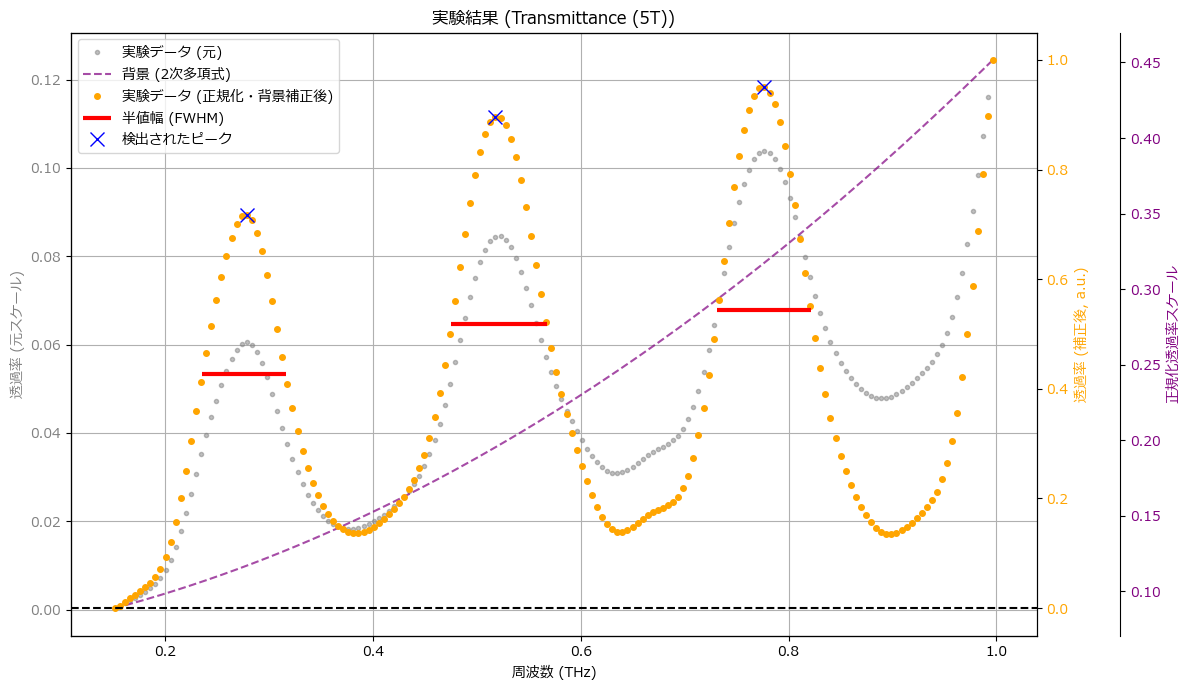

--- Transmittance (5T) の分析が完了 ---

--- Transmittance (7.7T) の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.2931 THz) の半値幅: 0.0584 THz
ピーク (周波数: 0.5227 THz) の半値幅: 0.0844 THz
ピーク (周波数: 0.7816 THz) の半値幅: 0.0794 THz
平均半値幅: 0.0819 THz
平均半値幅 (共振器): 0.0794 THz

--- 膜厚の計算 ---
2次周波数 (0.7816 THz) に基づく膜厚: 100.933μm
平均膜厚: 100.933μm


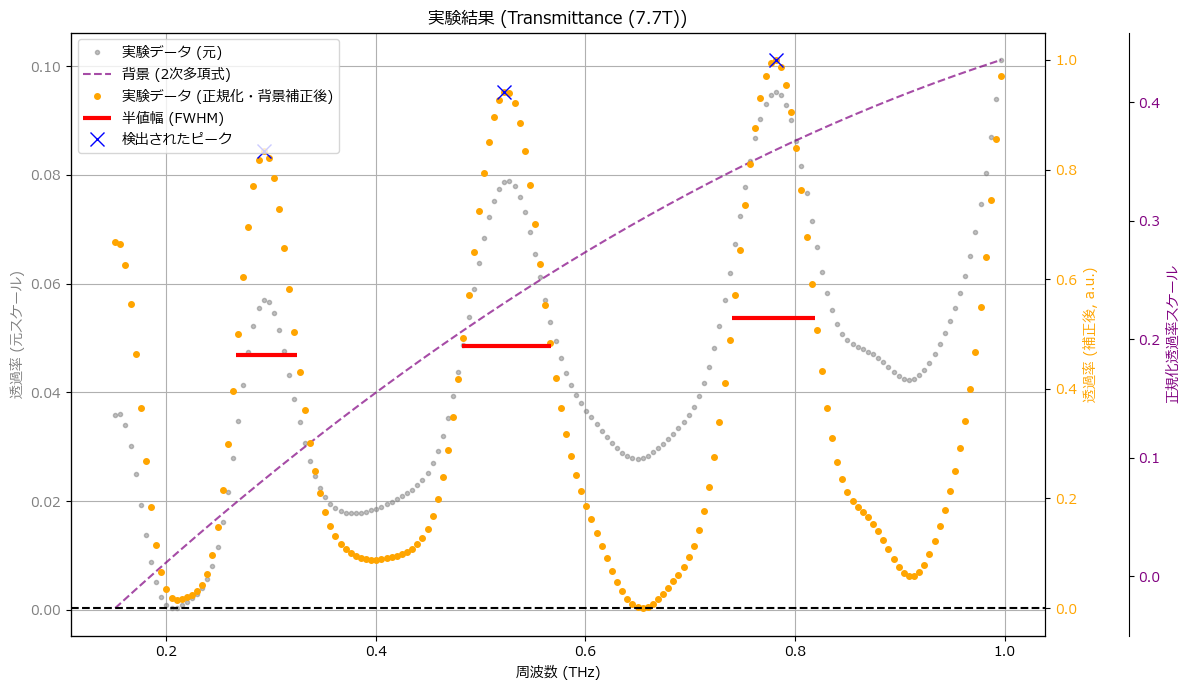

--- Transmittance (7.7T) の分析が完了 ---

--- Transmittance (9T) の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.1759 THz) の半値幅: 0.0329 THz
ピーク (周波数: 0.3127 THz) の半値幅: 0.0514 THz
ピーク (周波数: 0.3957 THz) の半値幅: 0.0231 THz
ピーク (周波数: 0.5276 THz) の半値幅: 0.0795 THz
ピーク (周波数: 0.7816 THz) の半値幅: 0.0814 THz
平均半値幅: 0.0514 THz
平均半値幅 (共振器): 0.0513 THz

--- 膜厚の計算 ---
2次周波数 (0.3957 THz) に基づく膜厚: 199.375μm
3次周波数 (0.5276 THz) に基づく膜厚: 224.296μm
平均膜厚: 211.836μm


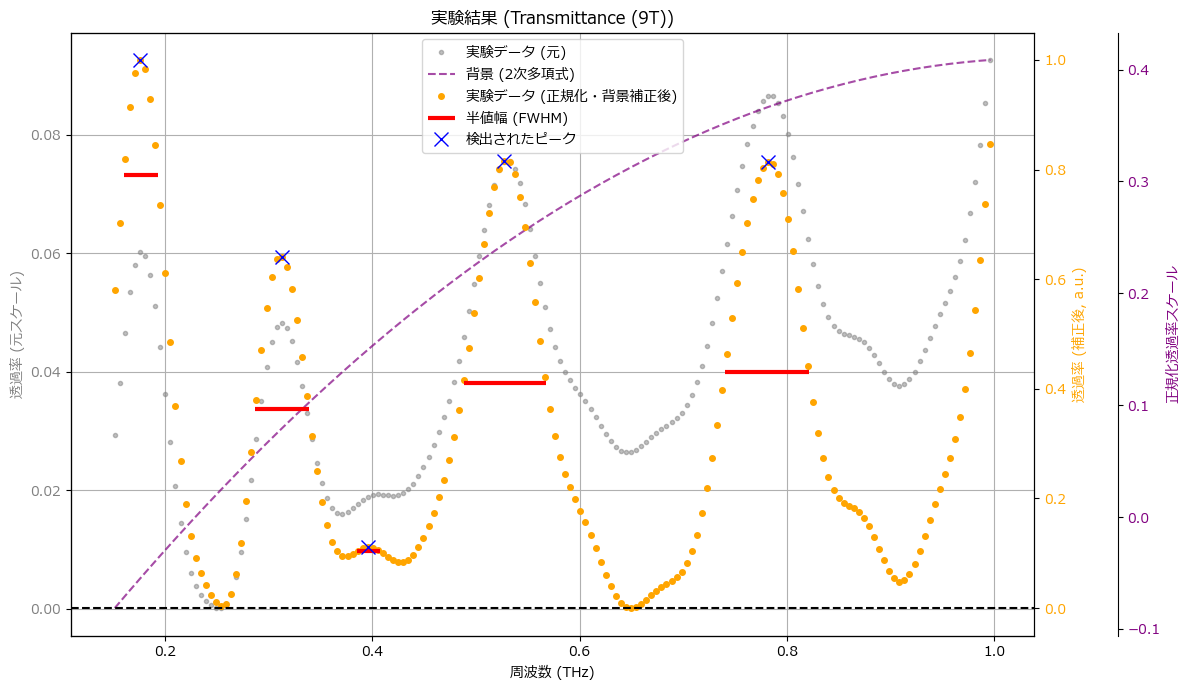

--- Transmittance (9T) の分析が完了 ---


補正後のデータを 'corrected_exp_datasets\Corrected_Transmittance_B_Field.xlsx' に保存しました。
保存された列: ['Frequency (THz)', 'Transmittance (5T)', 'Transmittance (7.7T)', 'Transmittance (9T)']
====== ファイル 'Circular_Polarization_B_Field.xlsx' の処理が完了 ======



In [7]:
# --- 磁場依存データの処理と保存 ---
process_file_and_save(
    file_path="Circular_Polarization_B_Field.xlsx",
    sheet_name="Sheet2",
    freq_col='Frequency (THz)',
    target_columns=['Transmittance (5T)', 'Transmittance (7.7T)', 'Transmittance (9T)'],
    output_filename="Corrected_Transmittance_B_Field.xlsx"
)

====== ファイル 'Circular_Polarization_Temparature.xlsx' の処理を開始 ======
データの読み込みに成功しました。読み込み件数: 174件
列名: ['Frequency (THz)', '4K', '30K', '100K', '300K']
--- 4K の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.1808 THz) の半値幅: 0.0365 THz
ピーク (周波数: 0.3078 THz) の半値幅: 0.0508 THz
ピーク (周波数: 0.5276 THz) の半値幅: 0.0808 THz
ピーク (周波数: 0.7816 THz) の半値幅: 0.0794 THz
平均半値幅: 0.0703 THz
平均半値幅 (共振器): 0.0801 THz

--- 膜厚の計算 ---
2次周波数 (0.5276 THz) に基づく膜厚: 149.531μm
3次周波数 (0.7816 THz) に基づく膜厚: 151.400μm
平均膜厚: 150.466μm


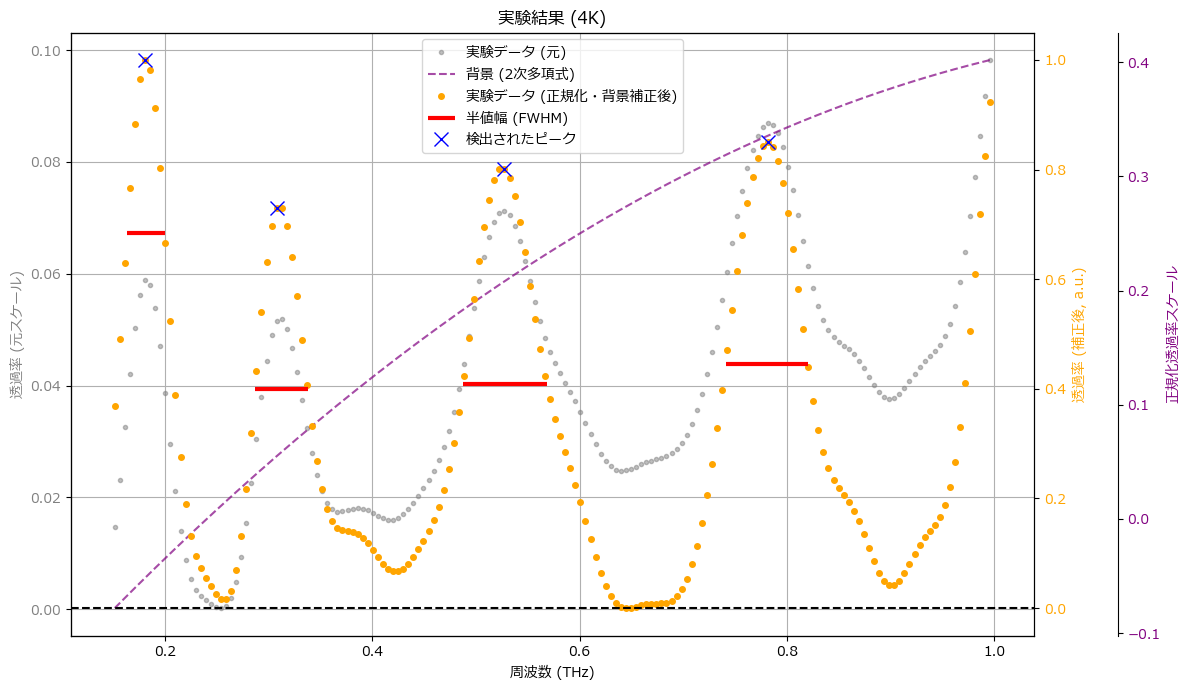

--- 4K の分析が完了 ---

--- 30K の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.2003 THz) の半値幅: 0.0444 THz
ピーク (周波数: 0.2931 THz) の半値幅: 0.0509 THz
ピーク (周波数: 0.5178 THz) の半値幅: 0.0860 THz
ピーク (周波数: 0.7719 THz) の半値幅: 0.0819 THz
平均半値幅: 0.0729 THz
平均半値幅 (共振器): 0.0840 THz

--- 膜厚の計算 ---
2次周波数 (0.5178 THz) に基づく膜厚: 152.352μm
3次周波数 (0.7719 THz) に基づく膜厚: 153.317μm
平均膜厚: 152.834μm


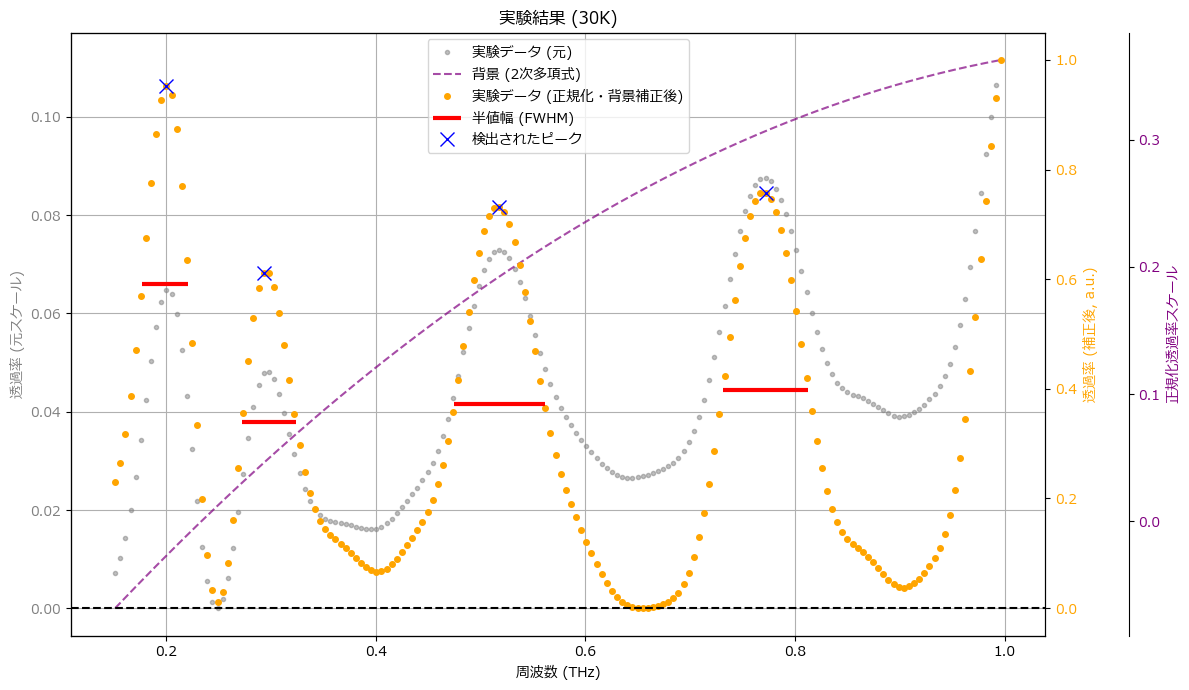

--- 30K の分析が完了 ---

--- 100K の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.2101 THz) の半値幅: 0.0397 THz
ピーク (周波数: 0.2882 THz) の半値幅: 0.0429 THz
ピーク (周波数: 0.3615 THz) の半値幅: 0.0167 THz
ピーク (周波数: 0.5081 THz) の半値幅: 0.0866 THz
ピーク (周波数: 0.7572 THz) の半値幅: 0.0857 THz
平均半値幅: 0.0487 THz
平均半値幅 (共振器): 0.0516 THz

--- 膜厚の計算 ---
2次周波数 (0.3615 THz) に基づく膜厚: 218.234μm
3次周波数 (0.5081 THz) に基づく膜厚: 232.923μm
平均膜厚: 225.579μm


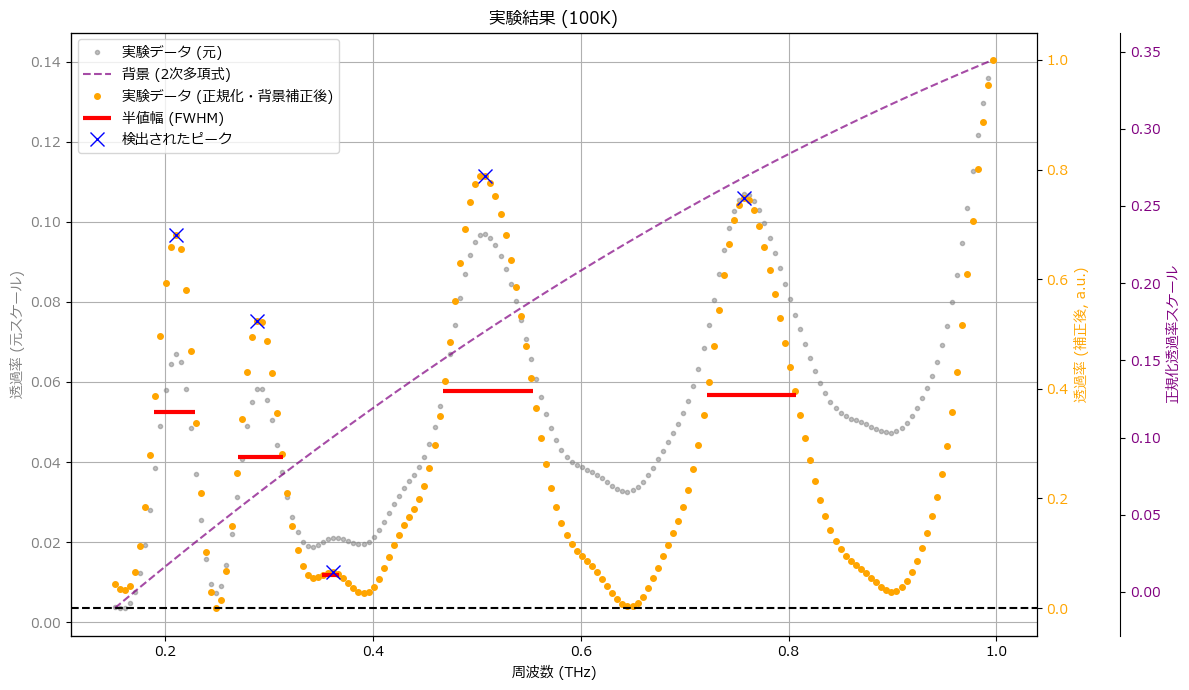

--- 100K の分析が完了 ---

--- 300K の分析を開始 ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.2101 THz) の半値幅: 0.0461 THz
ピーク (周波数: 0.2833 THz) の半値幅: 0.0323 THz
ピーク (周波数: 0.3517 THz) の半値幅: 0.0148 THz
ピーク (周波数: 0.4934 THz) の半値幅: 0.0687 THz
ピーク (周波数: 0.7328 THz) の半値幅: 0.0842 THz
ピーク (周波数: 0.9722 THz) の半値幅: 0.0396 THz
平均半値幅: 0.0386 THz
平均半値幅 (共振器): 0.0417 THz

--- 膜厚の計算 ---
2次周波数 (0.3517 THz) に基づく膜厚: 224.296μm
3次周波数 (0.4934 THz) に基づく膜厚: 239.842μm
平均膜厚: 232.069μm


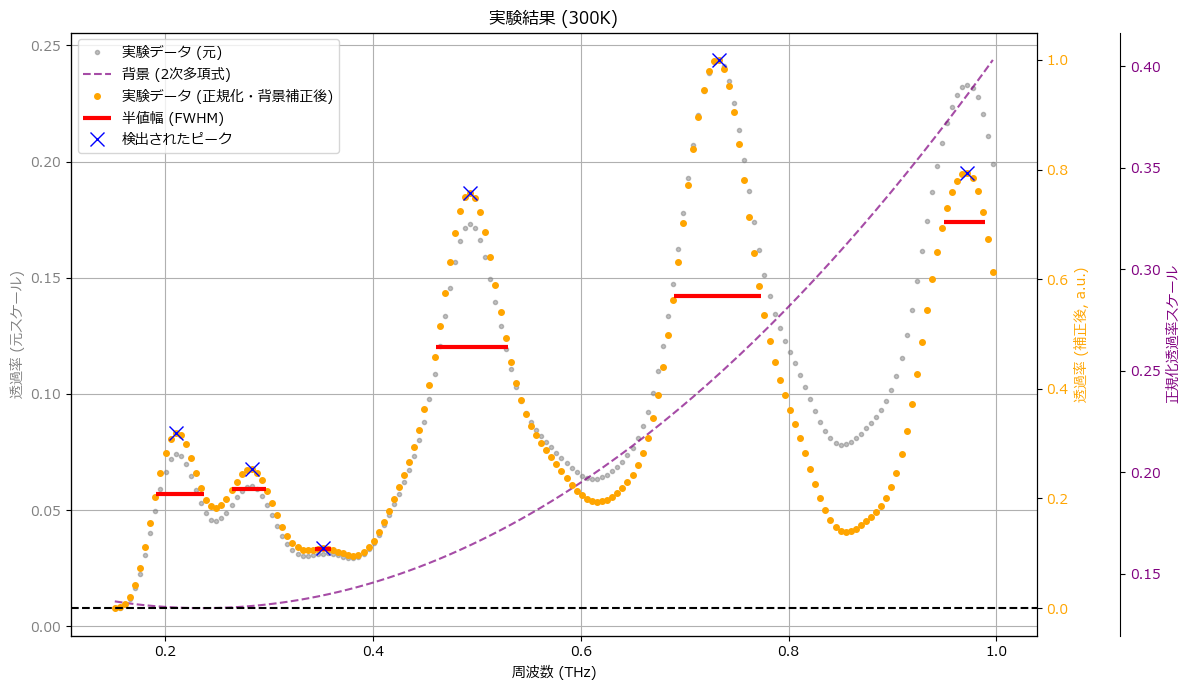

--- 300K の分析が完了 ---


補正後のデータを 'corrected_exp_datasets\Corrected_Transmittance_Temperature.xlsx' に保存しました。
保存された列: ['Frequency (THz)', '4K', '30K', '100K', '300K']
====== ファイル 'Circular_Polarization_Temparature.xlsx' の処理が完了 ======



In [8]:
# --- 温度依存データの処理と保存 ---
process_file_and_save(
    file_path="Circular_Polarization_Temparature.xlsx",
    sheet_name="limited",
    freq_col='Frequency (THz)',
    target_columns=['4K', '30K', '100K', '300K'],
    output_filename="Corrected_Transmittance_Temperature.xlsx"
)

====== ファイル 'Circular_Polarization_B_Field.xlsx' の処理を開始 (線形補間背景補正) ======
データの読み込みに成功しました。読み込み件数: 174件
列名: ['Frequency (THz)', 'Transmittance (5T)', 'Transmittance (7.7T)', 'Transmittance (9T)']
--- Transmittance (5T) の分析を開始 (線形補間背景補正) ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.2785 THz) の半値幅: 0.0759 THz
ピーク (周波数: 0.5178 THz) の半値幅: 0.0913 THz
ピーク (周波数: 0.7767 THz) の半値幅: 0.0891 THz
平均半値幅: 0.0902 THz
平均半値幅 (共振器): 0.0891 THz

--- 膜厚の計算 ---
2次周波数 (0.7767 THz) に基づく膜厚: 101.568μm
平均膜厚: 101.568μm


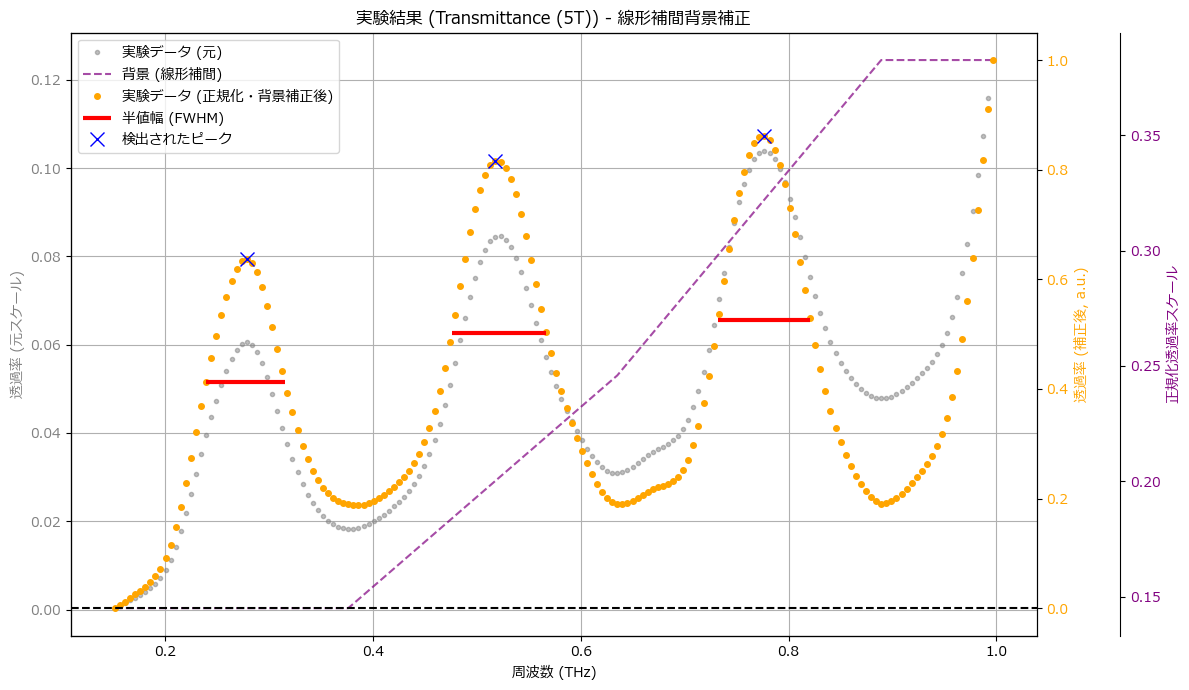

--- Transmittance (5T) の分析が完了 ---

--- Transmittance (7.7T) の分析を開始 (線形補間背景補正) ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.1563 THz) の半値幅: 0.0027 THz
ピーク (周波数: 0.2931 THz) の半値幅: 0.0599 THz
ピーク (周波数: 0.5227 THz) の半値幅: 0.0831 THz
ピーク (周波数: 0.7816 THz) の半値幅: 0.0815 THz
平均半値幅: 0.0748 THz
平均半値幅 (共振器): 0.0823 THz

--- 膜厚の計算 ---
2次周波数 (0.5227 THz) に基づく膜厚: 150.928μm
3次周波数 (0.7816 THz) に基づく膜厚: 151.400μm
平均膜厚: 151.164μm


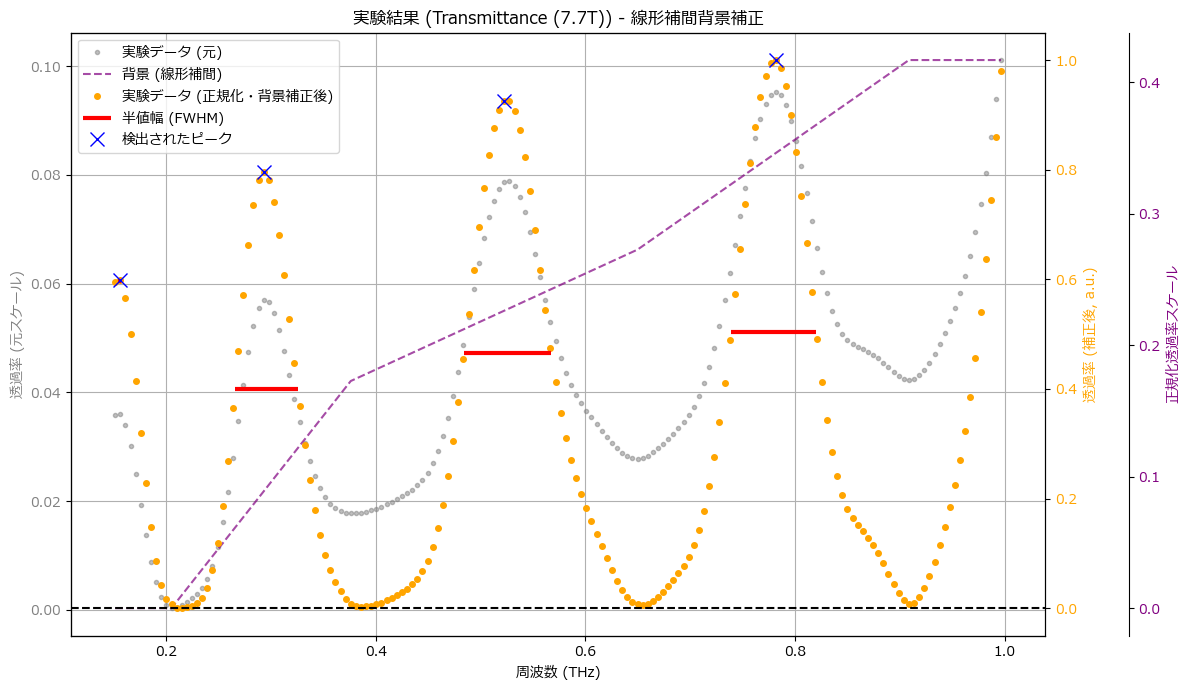

--- Transmittance (7.7T) の分析が完了 ---

--- Transmittance (9T) の分析を開始 (線形補間背景補正) ---
データの正規化が完了しました。
補正後データを[0, 1]の範囲にリスケールしました。

--- 半値幅 (FWHM) ---
ピーク (周波数: 0.1759 THz) の半値幅: 0.0347 THz
ピーク (周波数: 0.3127 THz) の半値幅: 0.0532 THz
ピーク (周波数: 0.4006 THz) の半値幅: 0.0226 THz
ピーク (周波数: 0.5276 THz) の半値幅: 0.0775 THz
ピーク (周波数: 0.7816 THz) の半値幅: 0.0839 THz
平均半値幅: 0.0511 THz
平均半値幅 (共振器): 0.0500 THz

--- 膜厚の計算 ---
2次周波数 (0.4006 THz) に基づく膜厚: 196.943μm
3次周波数 (0.5276 THz) に基づく膜厚: 224.296μm
平均膜厚: 210.620μm


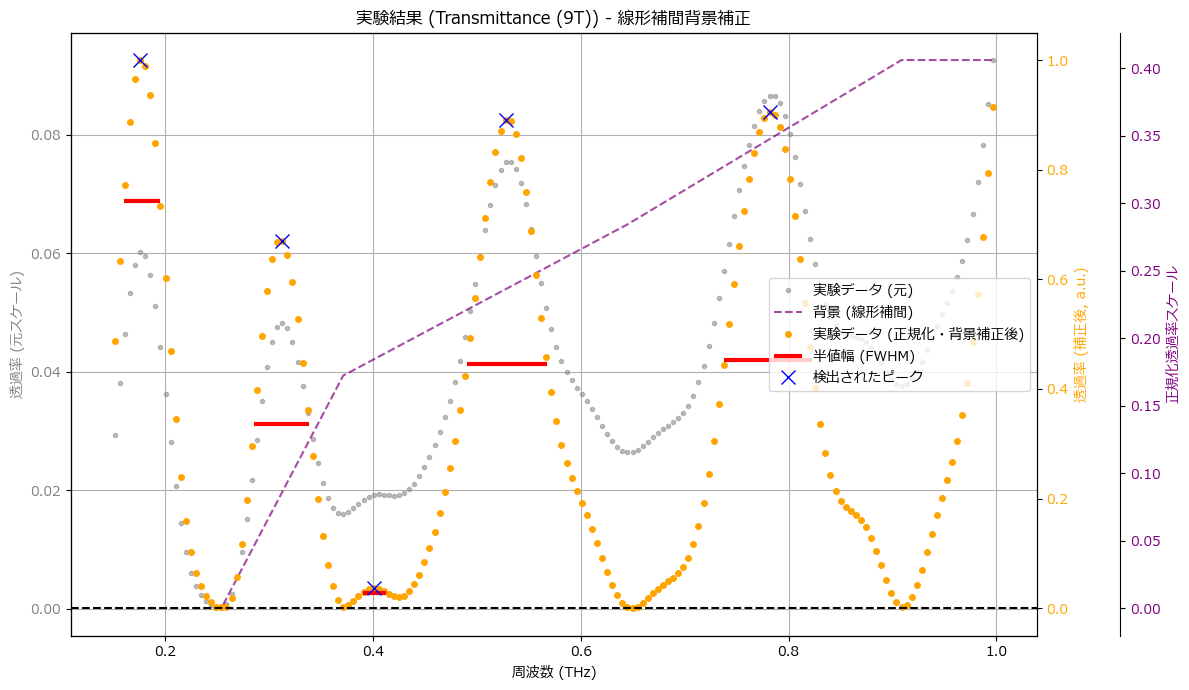

--- Transmittance (9T) の分析が完了 ---


補正後のデータを 'corrected_exp_datasets_linear\Corrected_Transmittance_B_Field_Linear.xlsx' に保存しました。
保存された列: ['Frequency (THz)', 'Transmittance (5T)', 'Transmittance (7.7T)', 'Transmittance (9T)']
====== ファイル 'Circular_Polarization_B_Field.xlsx' の処理が完了 (線形補間背景補正) ======



In [9]:
# --- 磁場依存データの処理と保存 (線形補間背景補正版) ---
process_file_and_save_linear_bg(
    file_path="Circular_Polarization_B_Field.xlsx",
    sheet_name="Sheet2",
    freq_col='Frequency (THz)',
    target_columns=['Transmittance (5T)', 'Transmittance (7.7T)', 'Transmittance (9T)'],
    output_filename="Corrected_Transmittance_B_Field_Linear.xlsx"
)